# Text Mining

In this script we are suppose to develop a program that can reads the json files generated by the news retriever and process this text in order to get it ready for the LDA Model.

In [3]:
!pip install wordcloud
!pip install pyLDAvis
!pip install -U future
!pip install nltk

Requirement already up-to-date: future in c:\users\usuario\documents\anaconda3\lib\site-packages (0.18.2)


In [4]:
!pip install stanza

In [9]:
import os 
import json as js
import pandas as pd
import re # El paquete para tratar texto. Expresiones regulares
from sklearn.feature_extraction.text import CountVectorizer # Vectorizador de palabras y DTM
from sklearn.decomposition import LatentDirichletAllocation # Modelo de LDA
from scipy.sparse import csr_matrix # Para tratar Sparse Matrix
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud #importo la función
import pyLDAvis # Paquete que crea la visualización
from pyLDAvis import sklearn as sklearnlda
import nltk
import stanfordnlp
import time
# LDA, tSNE
from sklearn.manifold import TSNE
# Visualization
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline
import seaborn as sns
# Bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider
from bokeh.layouts import column
from bokeh.palettes import all_palettes
from sklearn.decomposition import PCA

In [10]:
stfnlp=stanfordnlp.Pipeline(lang="es")

Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': 'C:\\Users\\usuario\\stanfordnlp_resources\\es_ancora_models\\es_ancora_tokenizer.pt', 'lang': 'es', 'shorthand': 'es_ancora', 'mode': 'predict'}
---
Loading: mwt
With settings: 
{'model_path': 'C:\\Users\\usuario\\stanfordnlp_resources\\es_ancora_models\\es_ancora_mwt_expander.pt', 'lang': 'es', 'shorthand': 'es_ancora', 'mode': 'predict'}
Building an attentional Seq2Seq model...
Using a Bi-LSTM encoder
Using soft attention for LSTM.
Finetune all embeddings.
---
Loading: pos
With settings: 
{'model_path': 'C:\\Users\\usuario\\stanfordnlp_resources\\es_ancora_models\\es_ancora_tagger.pt', 'pretrain_path': 'C:\\Users\\usuario\\stanfordnlp_resources\\es_ancora_models\\es_ancora.pretrain.pt', 'lang': 'es', 'shorthand': 'es_ancora', 'mode': 'predict'}
---
Loading: lemma
With settings: 
{'model_path': 'C:\\Users\\usuario\\stanfordnlp_resources\\es_ancora_models\\es_ancora_lemmatizer.pt', 'lang': 'es', 'shorthand': 'es_anco

In [11]:
os.chdir("C:\\Users\\usuario\\Desktop\\Universidad\\Proyectos Personales")
json_files=os.listdir(os.getcwd() + "\\News Retriever\\El_Tiempo")

In [12]:
json_files

['news_El_Tiempo_2020-04-13.json',
 'news_El_Tiempo_2020-04-15.json',
 'news_El_Tiempo_2020-04-16.json',
 'news_El_Tiempo_2020-04-17.json',
 'news_El_Tiempo_2020-04-18.json',
 'news_El_Tiempo_2020-04-19.json',
 'news_El_Tiempo_2020-04-20.json',
 'news_El_Tiempo_2020-04-21.json',
 'news_El_Tiempo_2020-04-22.json',
 'news_El_Tiempo_2020-04-23.json',
 'news_El_Tiempo_2020-04-24.json',
 'news_El_Tiempo_2020-04-25.json']

## Open Json Files

In [13]:
def text_cleaning(df):
    
    ## REVISAR QUE ERA LO QUE ELIMINA Juan Sebastian en la clase de 11 del taller de python
    #Turn all into lowercase
    df.contenido=df.contenido.str.lower() 
    # Eliminate all the content inside a parenthesis
    df.contenido=df.contenido.str.replace(r'\([^)]*\)', " ")
    # Unicode character found in the documents
    df.contenido=df.contenido.str.replace("\xa0", " ")
    # Unicode character found in the documents
    df.contenido=df.contenido.str.replace("\u200b", " ")
    # Eliminate all the @__name__
    df.contenido=df.contenido.str.replace("@[a-z]+", " ")
    #Turn all possible references of Coronavirus into one
    df.contenido=df.contenido.str.replace("(covid|corona virus)", "coronavirus")
    # Eiminate punctuation signs
    df.contenido=df.contenido.str.replace('[,\.%!?\-!?\n\)\(\r]', ' ') 
    # Eliminate numbers
    df.contenido=df.contenido.str.replace('[0-9]', ' ') # Quito números
    # Eliminate the name of the newspaper from the documents
    df.contenido=df.contenido.str.replace('eltiempo', '')
    # Eliminate the excess of whitespaces
    df.contenido=df.contenido.str.replace('  +', ' ')
    return df

<>:17: DeprecationWarning: invalid escape sequence \.
<>:17: DeprecationWarning: invalid escape sequence \.
<>:17: DeprecationWarning: invalid escape sequence \.
<ipython-input-13-8b3b2fb2b622>:17: DeprecationWarning: invalid escape sequence \.
  df.contenido=df.contenido.str.replace('[,\.%!?\-!?\n\)\(\r]', ' ')


In [14]:
def text_lemmatizer(df):   
    df["process_time"]=0
    for i in range(0,len(df["contenido"])):
        start=time.time()
        print(i)
        if len(df.loc[i,"contenido"].split(" ")) < 4000:
            doc= stfnlp(df.loc[i,"contenido"])
            df.loc[i,"contenido"]=" ".join([word.lemma for sentence in doc.sentences for word in sentence.words])
            end=time.time()
            df.loc[i,"process_time"]=end-start
        else:
            palabras=df.loc[i, "contenido"].split(" ")
            max_words=3500
            iteraciones= len(palabras)/max_words
            lemmatized_doc=" "
            for j in range(0,int(iteraciones)+1):
                last_j=min((j+1)*max_words, len(palabras))
                first_j=max(0,(j*max_words))
                content=" ".join(palabras[first_j:last_j])
                doc= stfnlp(content)
                lemmatized_doc=" ".join([word.lemma for sentence in doc.sentences for word in sentence.words])
            df.loc[i,"contenido"]= lemmatized_doc                  
            end=time.time()
            df.loc[i,"process_time"]=end-start
    return df
    

In [15]:
def text_processer_step_1(df):
    df=df[(df["contenido"]!='') & (df["contenido"]!=' ')]
    df.reset_index(drop=True, inplace=True)
    df=text_cleaning(df)
    df=text_lemmatizer(df)
    return df
    

In [16]:
for file in json_files:
    new_file_name=re.findall("(?<=news_).+(?=.json)", file)[0]+"_lemmatized"
    v=new_file_name+".json"
    json_lemmatized_files=os.listdir(os.getcwd() + "\\Text Mining\\process_text")
    if v not in json_lemmatized_files:
        print(new_file_name)
        with open(os.getcwd() + "\\News Retriever\\El_Tiempo\\"+file, 'r') as d:
            info_dict =js.load(d)
            df=pd.DataFrame(info_dict)
        df=text_processer_step_1(df)
        with open(os.getcwd()+"\\Text Mining\\process_text\\"+new_file_name+".json", 'w') as f:
            js.dump(df.to_dict(), f)
    else:
        print("The file "+file+" was already processed")


The file news_El_Tiempo_2020-04-13.json was already processed
The file news_El_Tiempo_2020-04-15.json was already processed
The file news_El_Tiempo_2020-04-16.json was already processed
The file news_El_Tiempo_2020-04-17.json was already processed
The file news_El_Tiempo_2020-04-18.json was already processed
The file news_El_Tiempo_2020-04-19.json was already processed
The file news_El_Tiempo_2020-04-20.json was already processed
The file news_El_Tiempo_2020-04-21.json was already processed
The file news_El_Tiempo_2020-04-22.json was already processed
The file news_El_Tiempo_2020-04-23.json was already processed
The file news_El_Tiempo_2020-04-24.json was already processed
El_Tiempo_2020-04-25_lemmatized


C:\Users\usuario\Documents\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0


C:\Users\usuario\Documents\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53


In [7]:

#\xa0
#\u200b
#Considerar eliminar todo lo que venga después del ultimo punto encontrado
#Considerar eliminar contenido dentro de parentsis...No tan buena idea, mejor eliminar parentesis o eliminar las que 
# cumplen con este formato (Lea también: El secreto a la hora de discutir de las parejas que son más felices)
# Eliminar ELTIEMPO



In [9]:
def text_cleaning(df):
    ## REVISAR QUE ERA LO QUE ELIMINA Juan Sebastian en la clase de 11 del taller de python
    #Turn all into lowercase
    df.contenido=df.contenido.str.lower() 
    # Eliminate all the content inside a parenthesis
    df.contenido=df.contenido.str.replace(r'\([^)]*\)', " ")
    # Unicode character found in the documents
    df.contenido=df.contenido.str.replace("\xa0", " ")
    # Unicode character found in the documents
    df.contenido=df.contenido.str.replace("\u200b", " ")
    # Eliminate all the @__name__
    df.contenido=df.contenido.str.replace("@[a-z]+", " ")
    #Turn all possible references of Coronavirus into one
    df.contenido=df.contenido.str.replace("(covid|corona virus)", "coronavirus")
    # Eiminate punctuation signs
    df.contenido=df.contenido.str.replace('[,\.%!?\-!?\n\)\(\r]', ' ') 
    # Eliminate numbers
    df.contenido=df.contenido.str.replace('[0-9]', ' ') # Quito números
    # Eliminate the name of the newspaper from the documents
    df.contenido=df.contenido.str.replace('eltiempo', '')
    # Eliminate the excess of whitespaces
    df.contenido=df.contenido.str.replace('  +', ' ')


<>:16: DeprecationWarning: invalid escape sequence \.
<>:16: DeprecationWarning: invalid escape sequence \.
<>:16: DeprecationWarning: invalid escape sequence \.
<ipython-input-9-3248da952f27>:16: DeprecationWarning: invalid escape sequence \.
  df.contenido=df.contenido.str.replace('[,\.%!?\-!?\n\)\(\r]', ' ')


## Preparing the Model

In [17]:
lemmatized_files=os.listdir(os.getcwd()+"\\Text Mining\\process_text")
lemmatized_files=[k for k in lemmatized_files if len(re.findall("E.+", k)) is not 0 ]
lemmatized_files

['El_Tiempo_2020-04-13_lemmatized.json',
 'El_Tiempo_2020-04-15_lemmatized.json',
 'El_Tiempo_2020-04-16_lemmatized.json',
 'El_Tiempo_2020-04-17_lemmatized.json',
 'El_Tiempo_2020-04-18_lemmatized.json',
 'El_Tiempo_2020-04-19_lemmatized.json',
 'El_Tiempo_2020-04-20_lemmatized.json',
 'El_Tiempo_2020-04-21_lemmatized.json',
 'El_Tiempo_2020-04-22_lemmatized.json',
 'El_Tiempo_2020-04-23_lemmatized.json',
 'El_Tiempo_2020-04-24_lemmatized.json',
 'El_Tiempo_2020-04-25_lemmatized.json']

In [18]:
df=pd.DataFrame({"categoria":[], "contenido":[],"link":[], "titulo":[], "process_time":[]})
for file in lemmatized_files:
    with open(os.getcwd()+"\\Text Mining\\process_text\\"+file, "r", encoding="utf-8") as t:
        info_dict =js.load(t)
        temp=pd.DataFrame(info_dict)
        df=df.append(temp)
df.shape

(643, 5)

In [40]:
# Now we load the stop words from a json file
with open(os.getcwd() + "\\Text Mining\\"+"spanish_stopwords.json", 'r' , encoding='utf-8') as d:
        stop_words=js.load(d)
stop_words=stop_words["words"]


In [41]:
# Now we create the document-word matrix, where each row is a document and each column is a word
n_vocab=350 # máximo tamaño de vocabulario
#We define the parameters that will be applied to the model creating an instance of it
tf_vectorizer = CountVectorizer(max_df=0.8, min_df=2, max_features=n_vocab, stop_words=stop_words, ngram_range=(1,3)) # Al igual que un modelo, defino el objeto que construirá la matriz
#We applied the model to a set of documents
tf = tf_vectorizer.fit_transform(df.contenido) # Aplico el objeto a un conjunto de textos
#We get the vocabulary
tf_feature_names = tf_vectorizer.get_feature_names() # Veo el vocabulario


In [42]:
#The matrix is save as a sparse matrix to make it occupy less space in memory and now we are going turn it into a dense
# matrix to be able to explore it 
TF_detallada=pd.DataFrame(csr_matrix(tf).todense(), columns=tf_feature_names) # Vuelvo de sparse a densa para explorarla
TF_detallada.head() #Veo las primeras 5 filas
print(TF_detallada.shape)

(643, 350)


In [43]:
# ¿Que tal si estudiamos las frecuencias de las palabras?
#We create a dataframe with the frequencies of the words used
frecuencias=pd.DataFrame(TF_detallada.sum(), index=tf_feature_names, columns=['Freq'])
#We sort the values 
frecuencias.sort_values(by=['Freq'], ascending=False, inplace=True)
frecuencias.head(15)

,Freq
persona,943
coronavirus,914
país,907
año,881
día,772
deber,718
salud,677
caso,657
medida,618
gobierno,617


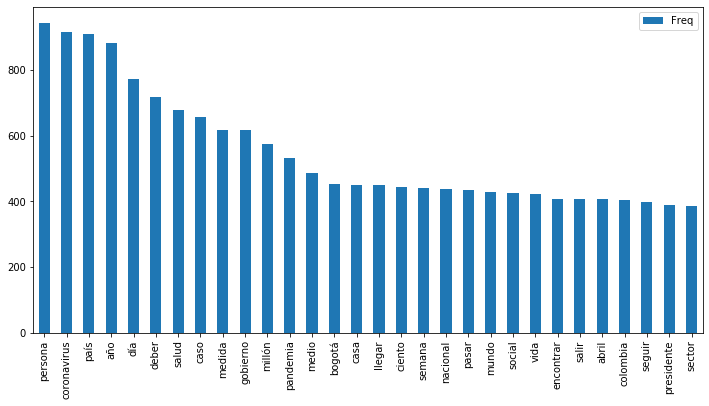

In [24]:
frecuencias.head(30).plot(kind='bar', figsize=(12,6))


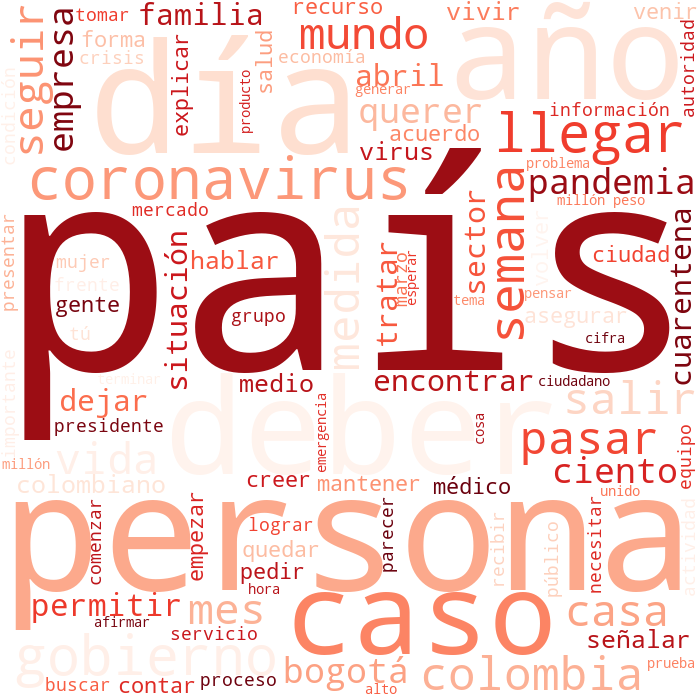

In [44]:
cloud=WordCloud(background_color='white', width=700, height=700, max_words=100, max_font_size=300, stopwords=tf_vectorizer.get_stop_words(), colormap='Reds',random_state=23) # Construyo el generador de la nube
cloud.generate('.'.join(list(df.contenido))) # Genero la nube
cloud.to_image()

# LDA
Is a generative statistical model that allows sets of observations to be explained by unobserved groups and in this way it can explained why some of the observations are similar between themselves. 

## Process 

### Pre Process Data

- Process the documents that will be used, get them all in a standard form
- Eliminate very short articles 
- Beware that some metadata or unicode characters could slip.

#### Words

Since LDA uses a bag of words methodology is very importatn to have the right words in the document, would want to eliminate very common words since they might not carry a very special meaning, or words that are only use once. We could also check for different things or focus on different aspects:

- **wordlength** (number of letters in the word) or (n-gram)
- **Stoplist** (Words that don't add much meaning to the document, general terms, )
- **Lemmatization** (interpretate as equal all the different conjugations of the same verb)
- **Parts of Speech**:
    + Noun
    + Verb
    + Adverb
    + Adjective
    + Preposition

### The Model

In the following link we can find a very good description about the intuition in the model and what it tries to do. 
https://towardsdatascience.com/lda-topic-modeling-an-explanation-e184c90aadcd

In [47]:
def create_model(k_topics):
    num_topics=k_topics # Cuántos tópicos deseo
    lda = LatentDirichletAllocation(n_components=num_topics, max_iter=20,doc_topic_prior=0.1, topic_word_prior=0.1, n_jobs=-1,random_state=23, verbose=1) # Construyo el objeto que es el modelo
    return lda.fit(tf) # Estimo el LDA

In [48]:
lda=create_model(12)

iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20
iteration: 5 of max_iter: 20
iteration: 6 of max_iter: 20
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20
iteration: 13 of max_iter: 20
iteration: 14 of max_iter: 20
iteration: 15 of max_iter: 20
iteration: 16 of max_iter: 20
iteration: 17 of max_iter: 20
iteration: 18 of max_iter: 20
iteration: 19 of max_iter: 20
iteration: 20 of max_iter: 20


In [49]:
print(lda.components_.shape) # De que tma~no es el resultado?
lda.components_ # Exploremos el resultado
#Inside the components matrix we have a matrix where each row is a topic and each columns a word. Therefore the element 
# inside the matrix A[i,j] can be viewed as pseudocount that represents the number of times word j was assigned to topic i

(12, 350)


array([[1.00705258e+01, 1.00049729e-01, 7.46241057e+00, ...,
        1.00026217e-01, 1.00027318e-01, 2.15487224e+01],
       [1.00023752e-01, 1.00014206e-01, 1.13098465e+01, ...,
        1.00009100e-01, 8.93960462e+00, 1.00020646e-01],
       [1.01948828e+02, 2.32666429e+00, 1.00023669e-01, ...,
        1.00022168e-01, 4.65374074e+01, 9.03814875e+00],
       ...,
       [1.67452769e+02, 2.67381963e+01, 4.87938486e+00, ...,
        2.42551685e+00, 4.63715382e+00, 1.00025749e-01],
       [6.86508757e+00, 1.00044164e-01, 2.32603467e+00, ...,
        1.08186969e+02, 1.00003838e-01, 1.00002474e-01],
       [4.33475080e+01, 2.72134816e+01, 7.06817239e+00, ...,
        1.00022370e-01, 1.00025925e-01, 3.90258513e+01]])

In [50]:
# Construyo la función que me ayuda a ver las palabras más importantes de cada tópico
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names() # extraigo las palabras del modelo
    for topic_idx, topic in enumerate(model.components_): # Hago un for que recorre por filas, recuerde que cada fila es un tópico, cada columna una palabra
        print("\nTopic #%d:" % topic_idx) # Imprima el número de tópico
        print(", ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]])) #Muestre las n palabras más importantes por orden 

AttributeError: 'numpy.ndarray' object has no attribute 'rows'

In [51]:
print_topics(lda, tf_vectorizer, 10)



Topic #0:
coronavirus, país, pandemia, unido, presidente, mundo, crisis, trump, chino, mundial

Topic #1:
ciento, persona, policía, cuarentena, hogar, aislamiento, casa, ciudadano, día, salir

Topic #2:
coronavirus, salud, caso, médico, mujer, año, hombre, bogotá, hospital, paciente

Topic #3:
red, jugar, fútbol, dato, grupo, internet, equipo, información, virtual, juego

Topic #4:
sector, gobierno, bogotá, empresa, nacional, presidente, salud, recurso, duque, social

Topic #5:
caso, cárcel, gobierno, justicia, señalar, persona, fiscalía, deber, proceso, policía

Topic #6:
deber, sistema, persona, problema, universidad, mantener, dejar, aire, tomar, forma

Topic #7:
servicio, pago, pagar, semana, empresa, nacional, proyecto, mes, creer, tú

Topic #8:
millón, peso, mercado, país, ciento, contrato, millón peso, fondo, precio, dólar

Topic #9:
medida, país, abril, salud, actividad, gobierno, contagio, salir, cuarentena, persona

Topic #10:
episodio, aplicación, spotify, aplicación spotif

In [52]:
def topics_word_distribution(model, count_vectorizer):
    num_topics,num_words= model.components_.shape
    topicos=["Topic #"+str(i) for i in range(0,num_topics)]
    matrix=pd.DataFrame(model.components_, index=topicos, columns=count_vectorizer.get_feature_names())
    return matrix

In [53]:
def most_important_words_per_topic(model, count_vectorizer, n_words):
    num_topics,num_words= model.components_.shape
    print(num_topics)
    words = count_vectorizer.get_feature_names() # extraigo las palabras del modelo
    topicos=["Topic #"+str(i) for i in range(0,num_topics)]
    resultado=pd.DataFrame(index=topicos, columns=["Word"+str(i) for i in range(1,n_words+1) ])
    resultado.fillna(" ")
    for topic in range(0,len(topicos)):
        resultado.iloc[topic,:]=[words[j] for j in model.components_[topic].argsort()[-n_words - 1:-1]]
    return(resultado)

In [54]:
most_important_words_per_topic(lda, tf_vectorizer,20)

12


,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10,Word11,Word12,Word13,Word14,Word15,Word16,Word17,Word18,Word19,Word20
Topic #0,tratar,salud,público,política,semana,gobierno,uu,ee uu,ee,económico,virus,mundial,chino,trump,crisis,mundo,presidente,unido,pandemia,país
Topic #1,frente,medio,obligatorio,colombiano,vida,calle,general,hora,acuerdo,afirmar,actividad,salir,día,ciudadano,casa,aislamiento,hogar,cuarentena,policía,persona
Topic #2,personal,registrar,país,abril,muerte,persona,llegar,prueba,autoridad,centro,contagio,paciente,hospital,bogotá,hombre,año,mujer,médico,caso,salud
Topic #3,medio,seguridad,usuario,bancario,red social,video,banco,social,mensaje,plataforma,digital,juego,virtual,información,equipo,internet,grupo,dato,fútbol,jugar
Topic #4,riesgo,familia,atender,necesitar,millón,ciudad,gobierno nacional,deber,colombia,crédito,transporte,social,duque,recurso,salud,presidente,nacional,empresa,bogotá,gobierno
Topic #5,investigación,alcalde,autoridad,decisión,pedir,año,medida,libertad,documento,derecho,general,policía,proceso,deber,fiscalía,persona,señalar,justicia,gobierno,cárcel
Topic #6,condición,medida,agua,virus,cambio,mano,pasar,nivel,alto,importante,día,forma,tomar,aire,dejar,mantener,universidad,problema,persona,sistema
Topic #7,gente,usuario,medida,negocio,año,día,público,deber,medio,pasar,canal,tú,creer,mes,proyecto,nacional,empresa,semana,pagar,pago
Topic #8,región,internacional,producto,económico,banco,economía,pandemia,coronavirus,colombia,año,producción,dólar,precio,fondo,millón peso,contrato,ciento,país,mercado,peso
Topic #9,mayo,permitir,decisión,economía,caso,riesgo,pico,aislamiento,día,restricción,deber,persona,cuarentena,salir,contagio,gobierno,actividad,salud,abril,país


In [55]:
# Como se ven los documentos?
lda_output=lda.transform(tf) # transformo la matrix de término-documento en tópico-documento
print(lda_output.shape) # Qué indican las dimensiones?
docs=['doc'+str(i) for i in range(lda_output.shape[0])] # Nombres de filas
topics=['topics'+str(i) for i in range(lda_output.shape[1])] # Nombres de columnas
lda_output=pd.DataFrame(lda_output, index=docs, columns=topics)

(643, 12)


In [56]:
# Exploremos la salida desde el punto de vista de documentos
lda_output.head().sum(axis=1) # Porque las filas suman 1?


doc0    1.0
doc1    1.0
doc2    1.0
doc3    1.0
doc4    1.0
dtype: float64

In [36]:
# Cómo se distribuye el documento promedio?
lda_output.head().mean(axis=0)

topics0     0.001351
topics1     0.117951
topics2     0.001351
topics3     0.047137
topics4     0.104750
topics5     0.001351
topics6     0.049414
topics7     0.036642
topics8     0.191610
topics9     0.163377
topics10    0.199111
topics11    0.085955
dtype: float64

In [57]:
# Creemos la pertenencia al tópicos
topico_dominante = np.argmax(lda_output.values, axis=1) 
lda_output['Topico_dominante']=topico_dominante
lda_output.head(10)

,topics0,topics1,topics2,topics3,topics4,topics5,topics6,topics7,topics8,topics9,topics10,topics11,Topico_dominante
doc0,0.000933,0.000933,0.000933,0.000933,0.000933,0.000933,0.000933,0.000933,0.000933,0.000933,0.989737,0.000933,10
doc1,0.021080,0.013626,0.000384,0.000384,0.000384,0.000384,0.140674,0.000384,0.591432,0.145773,0.000384,0.085108,8
doc2,0.000581,0.207014,0.000581,0.000581,0.187796,0.000581,0.242600,0.175128,0.022114,0.161863,0.000581,0.000581,6
doc3,0.001749,0.306607,0.001749,0.001749,0.099888,0.001749,0.001749,0.001749,0.334351,0.245165,0.001749,0.001749,8
doc4,0.003107,0.003107,0.003106,0.209313,0.207846,0.003107,0.003106,0.003106,0.003106,0.165867,0.003106,0.392122,11
doc5,0.001062,0.001062,0.001062,0.284835,0.166716,0.001062,0.001062,0.229544,0.310409,0.001062,0.001062,0.001062,8
doc6,0.001511,0.127831,0.456378,0.001511,0.001511,0.160799,0.242903,0.001511,0.001511,0.001511,0.001511,0.001511,2
doc7,0.000505,0.000505,0.000505,0.000505,0.000505,0.223005,0.000505,0.000505,0.764634,0.000505,0.007819,0.000505,8
doc8,0.000555,0.000555,0.074842,0.000555,0.046449,0.000555,0.278315,0.120875,0.336826,0.041670,0.000555,0.098248,8
doc9,0.000908,0.000908,0.000908,0.158054,0.000908,0.000908,0.000908,0.160422,0.076545,0.000908,0.013387,0.585238,11


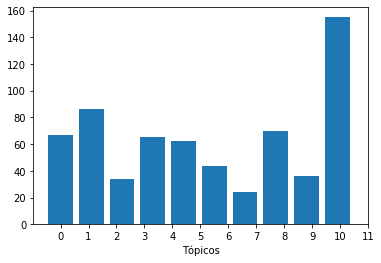

In [64]:
num_topics, num_words=lda.components_.shape
plt.hist(lda_output.Topico_dominante, density=False, rwidth=0.8, align='left')
plt.xlabel('Tópicos')
plt.xticks(range(num_topics));

## Evaluate Model Performance

### Diagnose model performance with perplexity and log-likelihood

A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. Let’s check for our model.



In [80]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(tf))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(tf))

Log Likelihood:  -375424.7937772929
Perplexity:  239.3519226838995


In [72]:
from sklearn.model_selection import GridSearchCV

[6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]

In [83]:
search_params={'n_components':list(range(6,30,2)), 'learning_decay': [.5, .7, .9], 'max_iter':list(range(5,30,5))}
len(search_params["n_components"])*len(search_params["learning_decay"])*len(search_params["max_iter"])

180

In [84]:
temp_lda=LatentDirichletAllocation()
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
model.fit(tf)

iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
iteration: 1 of max_

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=0.1,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=20,
                                                 mean_change_tol=0.001,
                                                 n_components=12, n_jobs=-1,
                                                 perp_tol=0.1, random_state=23,
                                                 topic_word_prior=0.1,
                                                 total_samples=1000000.0,
                

Best Model's Params:  {'learning_decay': 0.9, 'max_iter': 25, 'n_components': 8}
Best Log Likelihood Score:  -131273.39054834188
Model Perplexity:  243.6627153377519


In [90]:
model.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_learning_decay', 'param_max_iter', 'param_n_components', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [104]:
len(model.cv_results_["mean_test_score"])

180

In [105]:
len(model.cv_results_["params"])

180

In [97]:
for g in model.cv_results_:
    print(g)

mean_fit_time
std_fit_time
mean_score_time
std_score_time
param_learning_decay
param_max_iter
param_n_components
params
split0_test_score
split1_test_score
split2_test_score
mean_test_score
std_test_score
rank_test_score


In [109]:
# Get Log Likelyhoods from Grid Search Output
n_topics = list(range(6,30,2))
# log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if (gscore.parameters['learning_decay']==0.5) &
#                     (gscore.parameters["max_iter"]==5)]
# log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
# log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

max_iter_param=list(range(5,30,5))
learning_decay=[.5,.7,.9]
log_like={'log_like':[], "max_iter":[], "learning_decay":[], "n_components":[]}
for i in range(0,len(model.cv_results_["params"])):
    log_like["log_like"].append(model.cv_results_["mean_test_score"][i])
    log_like["max_iter"].append(model.cv_results_["params"][i]["max_iter"])
    log_like["learning_decay"].append(model.cv_results_["params"][i]["learning_decay"])
    log_like["n_components"].append(model.cv_results_["params"][i]["n_components"])
log_like=pd.DataFrame(log_like)


In [118]:
log_like.loc[(log_like["max_iter"]==20)&(log_like["learning_decay"]==0.5),:]

,log_like,max_iter,learning_decay,n_components
36,-131464.194491,20,0.5,6
37,-131357.712732,20,0.5,8
38,-131936.933250,20,0.5,10
39,-132520.180556,20,0.5,12
40,-133290.758338,20,0.5,14
41,-133698.503409,20,0.5,16
42,-134088.996474,20,0.5,18
43,-134613.532379,20,0.5,20
44,-135318.045921,20,0.5,22
45,-135922.293216,20,0.5,24


In [115]:
log_like.columns

Index(['log_like', 'max_iter', 'learning_decay', 'n_components'], dtype='object')

In [119]:
traces=[]
a=0
for w in max_iter_param:
    temp_trace=[]
    for c in learning_decay:
        print(a)
        temp_trace.append()
        a=a+1
    traces.append(temp_trace)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


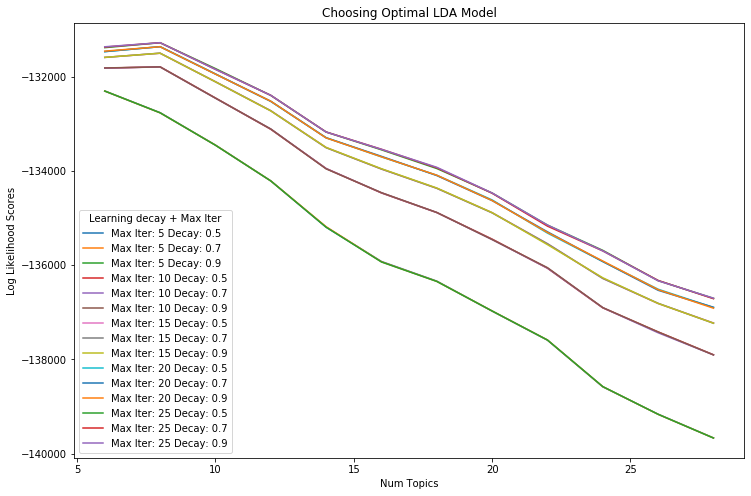

In [121]:
n_topics = list(range(6,30,2))
plt.figure(figsize=(12, 8))
for v in max_iter_param:
    for w in learning_decay:
        plt.plot(n_topics, list(log_like.loc[(log_like["max_iter"]==v)&(log_like["learning_decay"]==w),"log_like"]), 
                 label="Max Iter: "+str(v)+" Decay: "+str(w))
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelihood Scores")
plt.legend(title='Learning decay + Max Iter', loc='best')
plt.show()

In [ ]:
def grid_test(learning_decay_list,n_components_list):
    search_params={"learning_decay":learning_decay_list, "n_components":n_components_list}
    temp_lda=LatentDirichletAllocation(max_iter=15)
    print(len(learning_decay_list)*len(n_components_list))
# Init Grid Search Class
    model = GridSearchCV(temp_lda, param_grid=search_params)
    model.fit(tf)
    # Best Model
    best_lda_model = model.best_estimator_
    # Model Parameters
    print("Best Model's Params: ", model.best_params_)
    # Log Likelihood Score
    print("Best Log Likelihood Score: ", model.best_score_)
    # Perplexity
    print("Model Perplexity: ", best_lda_model.perplexity(tf))
# Get Log Likelihoods from Grid Search Output
    log_like={'log_like':[], "learning_decay":[], "n_components":[]}
     
    for i in range(0,len(model.cv_results_["params"])):
        log_like["log_like"].append(model.cv_results_["mean_test_score"][i])
        log_like["learning_decay"].append(model.cv_results_["params"][i]["learning_decay"])
        log_like["n_components"].append(model.cv_results_["params"][i]["n_components"])
    log_like=pd.DataFrame(log_like)
    
    plt.figure(figsize=(12, 8))
    for w in learning_decay_list:
        y=list(log_like.loc[log_like["learning_decay"]==w,"log_like"])
        
        plt.plot(n_components_list, y, 
                 label= "Decay: "+str(w)+"")
    plt.title("Choosing Optimal LDA Model")
    plt.xlabel("Num Topics")
    plt.ylabel("Log Likelihood Scores")
    plt.legend(title='Learning decay', loc='best')
    plt.show()
    return log_like


40
40
        log_like  learning_decay  n_components
0 -130313.139005             0.8             3
1 -130710.978138             0.8             4
2 -130442.860441             0.8             5
3 -130542.531650             0.8             6
4 -131129.865674             0.8             7
[-130313.1390051336, -130710.97813809087, -130442.860440937, -130542.53165033014, -131129.86567413516, -131658.79036996263, -131649.90003525393, -132392.4253681854, -132740.7411510743, -133329.57435334532]
[-130324.98673505099, -130169.42888240486, -130365.34929876741, -130615.65776979274, -131005.51437845071, -131361.13268207756, -131739.7613571279, -132297.0273293907, -132425.7093395996, -133091.6993984874]
[-130407.27029289723, -129997.05791221687, -130328.43284189096, -130593.77879240355, -130742.73266780184, -131156.62813476974, -131794.17371920586, -132572.30452742515, -132793.07263056756, -133239.44642716902]
[-130335.27731002058, -130345.31800788797, -130233.19750030174, -130857.5984686265, -130

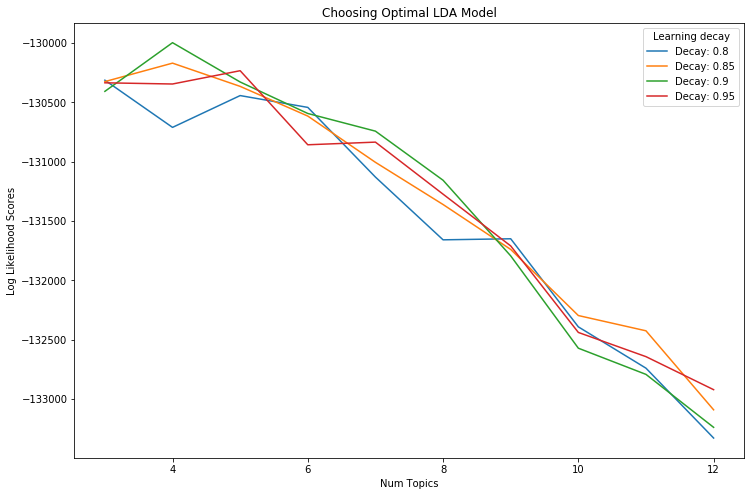

In [139]:
a=grid_test([0.8,0.85,0.9,0.95], list(range(3,13)))

In [ ]:
# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

## TSNE

In this part we will adjust the results of the model to calculate the T-SNE. Which is a probabilistic method of dimensionality reduction which tries to emulate certain distributions in the new space. T-distributed Stochastic Neighbor Embedding is a machine learning algorithm for visualization. It is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.

In [68]:
tsne = TSNE(random_state=2017, perplexity=30, early_exaggeration=120)
num_topics,num_words=lda.components_.shape
data=np.array(lda_output.iloc[:,1:num_topics])
embedding = tsne.fit_transform(data)
embedding = pd.DataFrame(embedding, columns=['x','y'])
embedding['hue'] =  np.argmax(data, axis=1)

In [89]:
all_palettes['Paired'][12]

['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']

In [69]:
source = ColumnDataSource(
        data=dict(
            x = embedding.x,
            y = embedding.y,
            colors = [all_palettes['Paired'][12][i] for i in embedding.hue],
            title = df.titulo,

        )
    )


hover_tsne = HoverTool(names=["df"], tooltips="""
    <div style="margin: 10">
        <div style="margin: 0 auto; width:300px;">
            <span style="font-size: 12px; font-weight: bold;">Title:</span>
            <span style="font-size: 12px">@title</span>
            <span style="font-size: 12px; font-weight: bold;">Year:</span>
            <span style="font-size: 12px">@year</span>
        </div>
    </div>
    """)

tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset']
plot_tsne = figure(plot_width=700, plot_height=700, tools=tools_tsne, title='News')
plot_tsne.circle('x', 'y', size=7, fill_color='colors', 
                 alpha=0.9, line_alpha=0, line_width=0.01, source=source, name="df")

show(plot_tsne)

## Principal Component Analysis
Here will try to reduce the dimensionality of our documents through principal component analysis, which is a deterministic method, that creates a new projection of the covariance matrix into the new space.

PCA can be thought of as fitting a p-dimensional ellipsoid to the data, where each axis of the ellipsoid represents a principal component. If some axis of the ellipsoid is small, then the variance along that axis is also small, and by omitting that axis and its corresponding principal component from our representation of the dataset, we lose only an equally small amount of information.

To find the axes of the ellipsoid, we must first subtract the mean of each variable from the dataset to center the data around the origin. Then, we compute the covariance matrix of the data and calculate the eigenvalues and corresponding eigenvectors of this covariance matrix. Then we must normalize each of the orthogonal eigenvectors to become unit vectors. Once this is done, each of the mutually orthogonal, unit eigenvectors can be interpreted as an axis of the ellipsoid fitted to the data. This choice of basis will transform our covariance matrix into a diagonalised form with the diagonal elements representing the variance of each axis. The proportion of the variance that each eigenvector represents can be calculated by dividing the eigenvalue corresponding to that eigenvector by the sum of all eigenvalues.

In [70]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)
x = pca_result[:,0]
y = pca_result[:,1] 
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
dominant_topic=list(np.argmax(data, axis=1))

Explained variation per principal component: [0.22334259 0.16244133]


In [71]:
source = ColumnDataSource(
        data=dict(
            x = list(x),
            y = list(y),
            colors = [all_palettes['Paired'][12][i] for i in dominant_topic],
            title = df.titulo,

        )
    )


hover_tsne = HoverTool(names=["df"], tooltips="""
    <div style="margin: 10">
        <div style="margin: 0 auto; width:300px;">
            <span style="font-size: 12px; font-weight: bold;">Title:</span>
            <span style="font-size: 12px">@title</span>
            <span style="font-size: 12px; font-weight: bold;">Year:</span>
            <span style="font-size: 12px">@year</span>
        </div>
    </div>
    """)

tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset']
plot_tsne = figure(plot_width=700, plot_height=700, tools=tools_tsne, title='News')
plot_tsne.circle('x', 'y', size=7, fill_color='colors', 
                 alpha=0.9, line_alpha=0, line_width=0.01, source=source, name="df")

show(plot_tsne)

## Hasta acá hemos entedido
Por ahora tenemos dominio del tema hasta este punto

## Tareas

Las tareas para las siguientes sesiones de trabajo son:
- Tunear el modelo de LDA
- Encontrar formas de lograr que la separación sea más notoria, ya sea en T-SNE o PCA
- Investigar como crear una app a traves de Dash

**Ideas Implementación en Dash**

- Gráfico lado izquierdo (PCA o TSNE)
- Tabla o Gráfica acerca de caracteristicas del tópico cuando se haga clic en alguna noticia en especial
- Tabla con caracteristicas acerca de la noticia seleccionada

**Ideas Finales**
- Encontrar una forma de lograr que las palabras no sean tan repetitivas entre los topicos
- Estudiar las stopwords, ver que le pueden faltar



In [111]:
%%time
# Juguemos con un hiper parámetro
likelihood=[]
values=[i for i in range(2,31,2)]
for i in values:
    modelo = LatentDirichletAllocation(n_components=i, max_iter=10,doc_topic_prior=0.1, topic_word_prior=0.1, n_jobs=-1,random_state=23) # Construyo el objeto que es el modelo
    modelo.fit(tf)
    likelihood.append(modelo.score(tf))
    print(i)

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
Wall time: 9.02 s


Text(0, 0.5, 'log-likelihood')

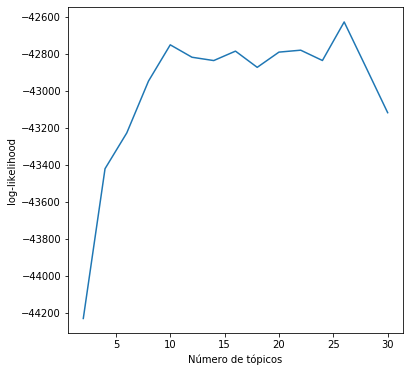

In [112]:
# Visualizamos
plt.figure(figsize=(6,6))
plt.plot(values, likelihood)
plt.xlabel('Número de tópicos')
plt.ylabel('log-likelihood')

In [328]:
LDAvis_prepared=sklearnlda.prepare(lda, tf, tf_vectorizer ) # Preparo el modelo y sus resultados para la visualización
pyLDAvis.save_html(LDAvis_prepared, 'LDA.html') # Guardo la visualización como html

C:\Users\usuario\Documents\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [191]:
os.getcwd()

'C:\\Users\\usuario\\Desktop\\Universidad\\Proyectos Personales'

In [329]:
pyLDAvis.display(LDAvis_prepared) # Lo visualizo dentro del notebook